<a href="https://colab.research.google.com/github/Tarleton-Math/data-science-20-21/blob/master/data_science_20_21_notes_09_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Intro to Sci-Kit Learn and Model Evaluation
## Class Notes 2020-09-22
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook

In [1]:
! pip install --upgrade numpy
! pip install --upgrade pandas

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.2)


We've written cross-validation and knn code by hand to strengthen our python skills.  But, let's face it - this is a lot of work.  And these are some of the simpler algorithms.

Scikit-learn offers a TON of pre-built data science algorithms that are both easier to use and much more powerful.  Let's start taking advantage of them.

First, meet "StratifiedKFold" and "StratifiedShuffleSplit".

- def: A cross-validation algorithm is *stratified* if it tried to ensure that all classes of the target variable are proportionately represented in each split.
    - Ex: Suppose we're working with the [Wisconsin breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) of biopsy result of 212 (37%) malignant and 357 (63%) benign breast tumors.  We want each split to have about the some proportions of malignant and benign obervations.
    - The cv techniques from prior notes do not intentionally do this.  But these "statified" versions so.

- *StratifiedKFold* is a stratified version of $k$-fold
- *StratifiedShuffleSplit* is a stratified version of "ShuffleSplit".
    - sklearn's "ShuffleSplit" is almost identical to delete-$d$, except it also shuffles the rows.  That's great - we can use it for the initial holdout/modeling split and it automatically takes care of shuffling the data for us!

In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy  # makes a copy of complex, nested data structures
from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

data = load_wine()
n, d = data.data.shape
X, y = data.data, data.target

holdout_frac = 0.1
holdout_splitter = StratifiedShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X[model_idx]  , y[model_idx]
X_h, y_h = X[holdout_idx], y[holdout_idx]
X_m.shape, X_h.shape

((160, 13), (18, 13))

More useful sklearn functions
- Pipeline - Allows us to chain together several steps into one object; particularly handy to make cross-validation easier.
- confusion_matrix - Our model will predict which class it believes each validation observation belongs to.  Sometimes that prediction is right, sometimes it is wrong.  The confusion matrix counts these up.

def: Let $q$ be the number of classes of the (categorical) target variable. The *confusion matrix* $C$ is a $q \times q$ matrix where:
- $C_{ij}$ = # of observations that ACTUALLY belong to class $i$ and are PREDICTED to be in class $j$.
- The diagonal represents correct predictions; all other entries represent incorrect predictions.
- def: *accuracy* = # correct predictions / total # of predictions = sum of C's diagonal / sum of all entries of C = C.trace() / C.sum()

Other package used below:
- matplotlib - the core visualization package
    - There are now many visualization packages that are better than matplotlib.  But most are built on top of matplotlib.
    - Many experience python coders still reach for matplotlib first because we're comfortable with it even though we know there are better options now available.
- seaborn - One (of the many) better visualization package built on top of matplotlib.  Here, we use for a pretty version on the confusion matrix.


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def run_model(X, y, pipe, show_confusion=True, n_splits=10):
    """ Inputs: X (features), Y (targets), pipe (classification pipeline)
    show_confusion (whether to display confusion matrix
    n_splits (number of cross-validation iterations)
    """
    
    acc = []  # each split produces an accuracy, store into acc
    cfs = []  # each split produces a confusion matrix, store into cfs
    train_splitter = StratifiedKFold(n_splits)  # create splitter object
    f = 0  # tracks number of splits already completed
    for train, valid in train_splitter.split(X, y):  # loop over the splits
        y_true = y[valid]  # true classes for validation set
        y_pred = pipe.fit(X[train], y[train]).predict(X[valid])  # predicted classes for validation set
        # note we "fit" or "train" the model (pipe) using the training set
        # then we apply that trained model to the validation set

        cf = confusion_matrix(y_true, y_pred)  # create the confusion matrix
        a = cf.trace() / cf.sum()  # compute the accuract
        acc.append(a)  # record the accuracy
        cfs.append(cf) # record the confusion matrix
        if show_confusion:  # dislay the confusion matrix, if so desired
            print(f"Confusion matrix for fold {f} for {pipe.named_steps['classify'].n_neighbors} neighbors")
            display_confusion_matrix(cf)
        f += 1  # increment the count of complete splits
    return {'acc':acc, 'cfs':cfs, 'acc_mean':np.mean(acc)*100}

def display_confusion_matrix(cf):
    """Pretty display for confusion matrix"""
    sns.heatmap(cf, annot=True)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

def display_results(df):
    """Pretty display of later results dataframe - nothing important here"""
    df = df.astype('float')
    with pd.option_context("display.max_rows", 1000):
        display(df.style.set_precision(2)
            .highlight_max(axis=0, color='green')
            .set_properties(**{'text-align':'center', 'border-width':'thin','border-style':'dotted'})
            .set_table_attributes('style="border-collapse:collapse"')
        )
    return df
    

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's use these functions to run KNN.

Confusion matrix for fold 0 for 5 neighbors


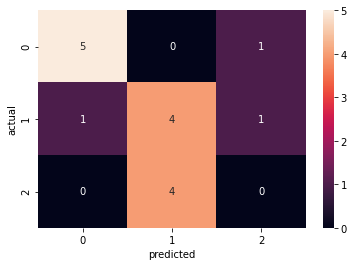

Confusion matrix for fold 1 for 5 neighbors


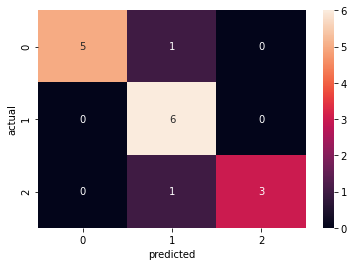

Confusion matrix for fold 2 for 5 neighbors


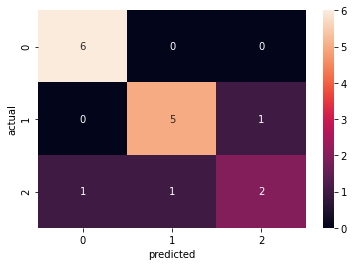

Confusion matrix for fold 3 for 5 neighbors


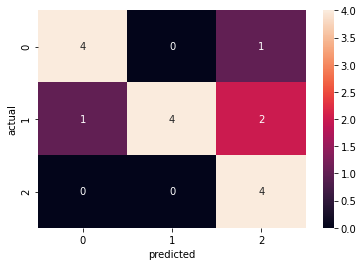

Confusion matrix for fold 4 for 5 neighbors


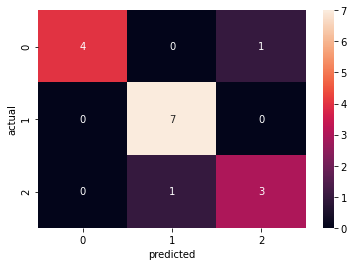

Confusion matrix for fold 5 for 5 neighbors


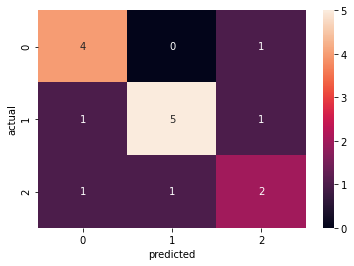

Confusion matrix for fold 6 for 5 neighbors


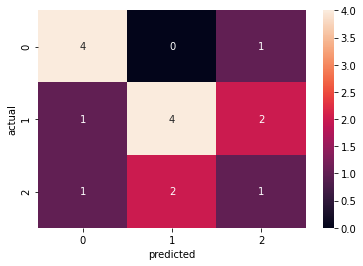

Confusion matrix for fold 7 for 5 neighbors


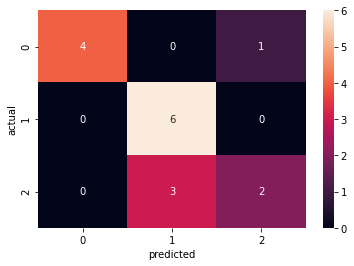

Confusion matrix for fold 8 for 5 neighbors


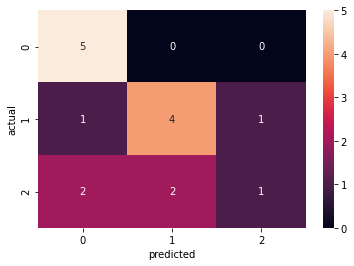

Confusion matrix for fold 9 for 5 neighbors


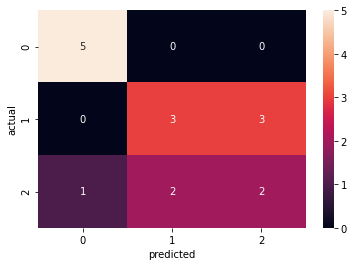

Mean accuracy over all cross-validations is 71.25%


In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Create a pipeline with just 1 step ... apply KNN with k=5
pipe = Pipeline([('classify', KNeighborsClassifier(n_neighbors=5))])

# run that model
res = run_model(X_m, y_m, pipe, show_confusion=True)
print(f"Mean accuracy over all cross-validations is {res['acc_mean']}%")

Hey, that accuracy sucks!  If we were randomly guessing, we expected to guess right about 1/3=33% of the time because there are 3 roughly balanced classes.  Our "smart" classifier should be able to beat random guessing by more than it is.  What's wrong?

Let's look at some descriptive info about the features again.





In [5]:
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

Look at "Magnesium" vs "Nonflavanoid Phenols".  They're on totally different scales.  One has mean 99.7 while the other has mean 0.36.  The MIN for Magnesium is more than 100 x MAX of Nonflavanoid Phenols.

This scale problem screws up KNN b/c it does its job based on distances.  Distances in the "Magnesium direction" competely swamp distances in the "Nonflavanoid Phenols direction".  In essence, the small features get ignored.

We need to fix this so that all features have roughly equal weight.  We need the rescale the columns BEFORE applying KNN.

Confusion matrix for fold 0 for 5 neighbors


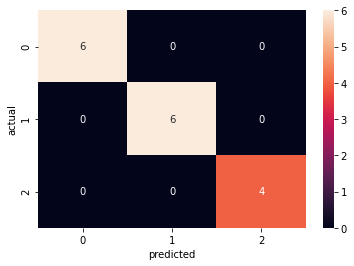

Confusion matrix for fold 1 for 5 neighbors


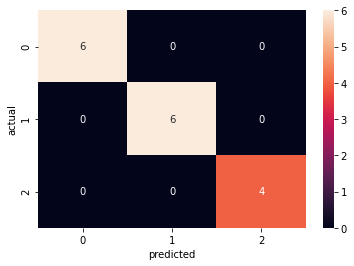

Confusion matrix for fold 2 for 5 neighbors


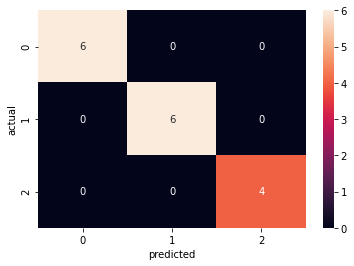

Confusion matrix for fold 3 for 5 neighbors


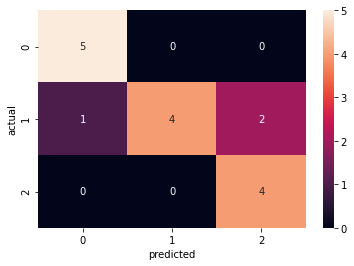

Confusion matrix for fold 4 for 5 neighbors


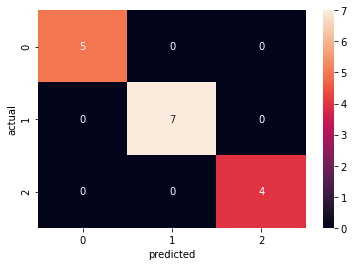

Confusion matrix for fold 5 for 5 neighbors


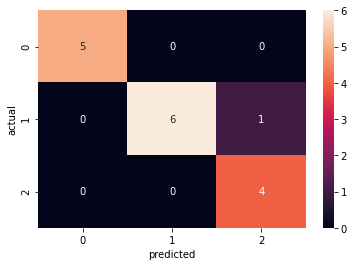

Confusion matrix for fold 6 for 5 neighbors


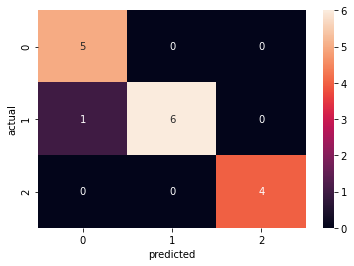

Confusion matrix for fold 7 for 5 neighbors


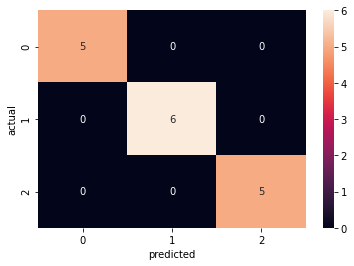

Confusion matrix for fold 8 for 5 neighbors


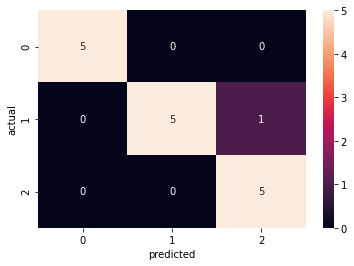

Confusion matrix for fold 9 for 5 neighbors


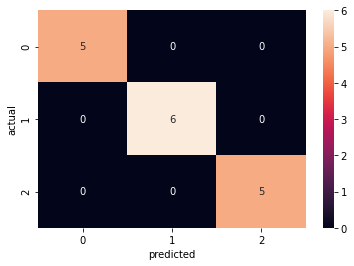

Mean accuracy over all cross-validations is 96.25%


In [6]:
from sklearn.preprocessing import StandardScaler

# Create a pipeline with just 2 steps ... scale then apply KNN with k=5
pipe = Pipeline([('scale', StandardScaler()),
                 ('classify', KNeighborsClassifier(n_neighbors=5))])
res = run_model(X_m, y_m, pipe, show_confusion=True)
print(f"Mean accuracy over all cross-validations is {res['acc_mean']}%")

Oh, that is MUCH better.  And it requires ALMOST no extra coding - just add the scaler to the front of the pipeline!

Now, let's tune our model.  The main hyperparameter is n_neighbors used by KNN.  So, let's loop over several options and look at the results.

In [10]:
df_results = pd.DataFrame(columns=['n_neighbors', 'acc_mean']).set_index('n_neighbors')  # write results in here
for n_neighbors in np.arange(1, 11):  # loop over a range of n_neighbor options
    pipe = Pipeline([('scale'   , StandardScaler()),
                     ('classify', KNeighborsClassifier(n_neighbors))])
    res = run_model(X_m, y_m, pipe, show_confusion=False)
    df_results.loc[n_neighbors, 'acc_mean'] = res['acc_mean']  # record results into df_results
display_results(df_results);  # pretty prints df_results (see above for the display_results fcn)

,acc_mean
n_neighbors,
1,95.00
2,94.38
3,95.62
4,94.38
5,96.25
6,94.38
7,98.12
8,95.62
9,95.62


Okay, n_neighbors=7 looks optimal.

Do we NEED to use all 13 columns?  Or could we get away with some dimensionality reduction?

Let's try throwing in PCA.  We must do PCA after scaling and before KNN.

In [11]:
from sklearn.decomposition import PCA

df_results = pd.DataFrame(columns=['n_components', 'n_neighbors', 'acc_mean']).set_index(['n_components', 'n_neighbors'])
for n_components in np.arange(1, d+1):  # max n_components = number of features = d
    for n_neighbors in np.arange(1, 11):
        pipe = Pipeline([('scale'     , StandardScaler()),
                         ('dim_reduce', PCA(n_components=n_components)),
                         ('classify'  , KNeighborsClassifier(n_neighbors))])
        res = run_model(X_m, y_m, pipe, show_confusion=False)
        df_results.loc[(n_components, n_neighbors), 'acc_mean'] = res['acc_mean']
display_results(df_results.unstack(0));

Obervations
- The very best accuracy is 98.12% when n_neighbors=7, n_components=13.
    - That means we'd keep all columns; no dim reductions
- Most rows are very stable except for the first column n_component=1
- The row for n_neighbors=7 is best (or tied) in all but 3 columns/n_components.  This is a good reason to stick with n_neighbors=7.
- If we want some dim reduction and don't mind losing 0.72% accuracy, (n_neighbors=7, n_components=3) looks good.
- So, based on this, I'd conclude that (n_neighbors=7, n_components=13) and (n_neighbors=7, n_components=3) are the best models.
